In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense , Flatten , MaxPooling2D, Conv2D, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve

C:\Users\keval\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = 'C:/Users/keval/OneDrive/Desktop/dataset' ,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    labels="inferred",
    label_mode="int"
)

Found 2112 files belonging to 2 classes.
Using 1690 files for training.


In [4]:
import numpy as np
from collections import Counter

# Extract the labels from the dataset
labels = []
for _, batch_labels in train_dataset:
    labels.extend(batch_labels.numpy())  # Convert Tensor to NumPy array

# Count the occurrences of each label
label_counts = Counter(labels)

# Get the class names
class_names = train_dataset.class_names

# Print the count for each class
for label, count in label_counts.items():
    print(f"Class '{class_names[label]}': {count} samples")

Class 'normal': 838 samples
Class 'cataract': 852 samples


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = 'C:/Users/keval/OneDrive/Desktop/dataset',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    labels="inferred",
    label_mode="int"
)

Found 2112 files belonging to 2 classes.
Using 422 files for validation.


In [6]:
train_dataset.class_names

['cataract', 'normal']

In [7]:
import numpy as np
from collections import Counter

# Extract the labels from the dataset
labels = []
for _, batch_labels in validation_dataset:
    labels.extend(batch_labels.numpy())  # Convert Tensor to NumPy array

# Count the occurrences of each label
label_counts = Counter(labels)

# Get the class names
class_names = validation_dataset.class_names

# Print the count for each class
for label, count in label_counts.items():
    print(f"Class '{class_names[label]}': {count} samples")


Class 'normal': 236 samples
Class 'cataract': 186 samples


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation

# Augmentation pipeline
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])

# Unbatch the dataset to work on individual samples
unbatched_data = train_dataset.unbatch()

# Define the maximum number of samples per class
max_samples = 1098  # Adjust this based on your dataset

# Augmented datasets for each class
augmented_datasets = []

for class_index, class_name in enumerate(train_dataset.class_names):
    # Filter for a specific class
    class_data = unbatched_data.filter(lambda x, y: y == class_index)
    
    # Augment and repeat data
    augmented_class = class_data.map(lambda x, y: (data_augmentation(x), y)).repeat().take(max_samples)
    augmented_datasets.append(augmented_class)

# Combine all classes into a balanced dataset
balanced_data = tf.data.Dataset.sample_from_datasets(augmented_datasets)

# Double the dataset by repeating the balanced dataset
balanced_data = balanced_data.concatenate(balanced_data)

In [9]:
balanced_data = balanced_data.batch(32)

In [10]:
balanced_data = balanced_data.map(lambda x, y: (x / 255.0, y))

In [11]:
validation_dataset = validation_dataset.map(lambda x, y: (x / 255.0, y))

In [12]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [13]:
augmented_data = balanced_data.map(augment_image)

In [14]:
model = Sequential()

In [15]:
from tensorflow.keras import regularizers

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and dense layers
model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(4, activation='softmax'))  # Adjust the number of units to match your classes

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                      

In [17]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [19]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=15,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0,
)

In [20]:
fit_hist = model.fit(balanced_data,epochs=150, batch_size=64 ,validation_data=validation_dataset, callbacks=[callback, reduce_lr])

Epoch 1/150
138/138 [==============================] - 1139s 8s/step - loss: 3.3205 - accuracy: 0.5931 - val_loss: 1.8471 - val_accuracy: 0.4408 - lr: 0.0010
Epoch 2/150
138/138 [==============================] - 404s 3s/step - loss: 1.5170 - accuracy: 0.7557 - val_loss: 1.9309 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 3/150
138/138 [==============================] - 392s 3s/step - loss: 1.3443 - accuracy: 0.8270 - val_loss: 1.7984 - val_accuracy: 0.4408 - lr: 0.0010
Epoch 4/150
138/138 [==============================] - 389s 3s/step - loss: 1.0509 - accuracy: 0.8461 - val_loss: 1.8465 - val_accuracy: 0.4573 - lr: 0.0010
Epoch 5/150
138/138 [==============================] - 365s 3s/step - loss: 1.0637 - accuracy: 0.8711 - val_loss: 1.2066 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 6/150
138/138 [==============================] - 379s 3s/step - loss: 0.8961 - accuracy: 0.8859 - val_loss: 0.7821 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 7/150
138/138 [==============================] - 37

In [21]:
import pickle

In [24]:
history_path = "C:\\Users\\keval\\OneDrive\\Desktop\\MiniProject\\Catract_history.pkl"
with open(history_path, 'wb') as file:
    pickle.dump(fit_hist.history, file)

In [25]:
model_path = "C:\\Users\\keval\\OneDrive\\Desktop\\MiniProject\\Catract_CNNModel.keras"
model.save(model_path)

In [1]:
#Load Model
from tensorflow.keras.models import load_model

# Load the model
model_path = model_path = "C:\\Users\\keval\\OneDrive\\Desktop\\MiniProject\\Catract_CNNModel.keras"
model = load_model(model_path)


C:\Users\keval\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [26]:
!pip install gradio

   ---------------------------------------- 0.0/57.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/57.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/57.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/57.5 MB ? eta -:--:--
   ---------------------------------------- 0.5/57.5 MB 730.2 kB/s eta 0:01:19
   ---------------------------------------- 0.5/57.5 MB 730.2 kB/s eta 0:01:19
    --------------------------------------- 0.8/57.5 MB 714.3 kB/s eta 0:01:20
    --------------------------------------- 1.0/57.5 MB 729.5 kB/s eta 0:01:18
    --------------------------------------- 1.0/57.5 MB 729.5 kB/s eta 0:01:18
    --------------------------------------- 1.3/57.5 MB 721.7 kB/s eta 0:01:18
    --------------------------------------- 1.3/57.5 MB 721.7 kB/s eta 0:01:18
   - -------------------------------------- 1.6/57.5 MB 723.0 kB/s eta 0:01:18
   - -------------------------------------- 1.6/57.5 MB 723.0 kB/s eta 0:01:18
   - ----

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
anaconda-cloud-auth 0.1.3 requires pydantic<2.0, but you have pydantic 2.10.5 which is incompatible.
s3fs 2023.4.0 requires fsspec==2023.4.0, but you have fsspec 2024.12.0 which is incompatible.


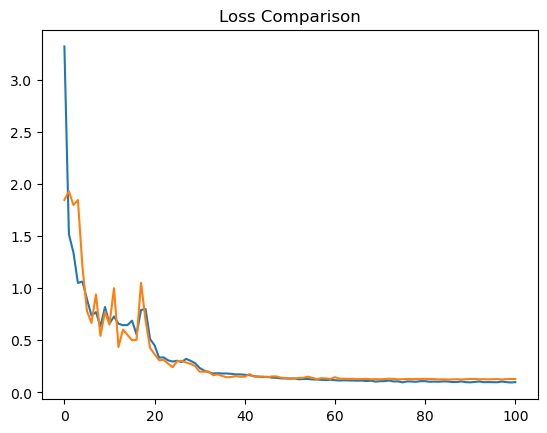

In [28]:
plt.plot(fit_hist.history['loss'])
plt.plot(fit_hist.history['val_loss'])
plt.title('Loss Comparison')
plt.show()

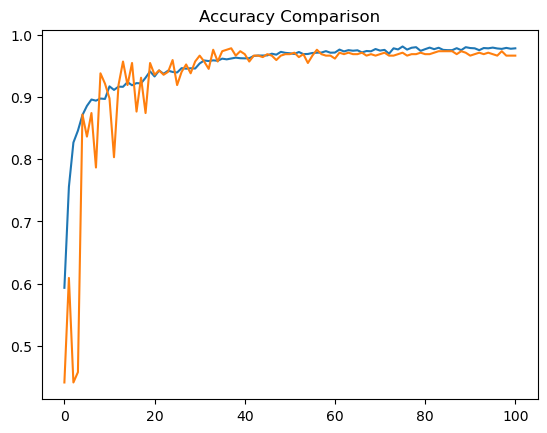

In [29]:
plt.plot(fit_hist.history['accuracy'])
plt.plot(fit_hist.history['val_accuracy'])
plt.title('Accuracy Comparison')
plt.show()

1/1 [==============================] - 0s 398ms/step
Length of y_true: 422
Length of y_pred: 422


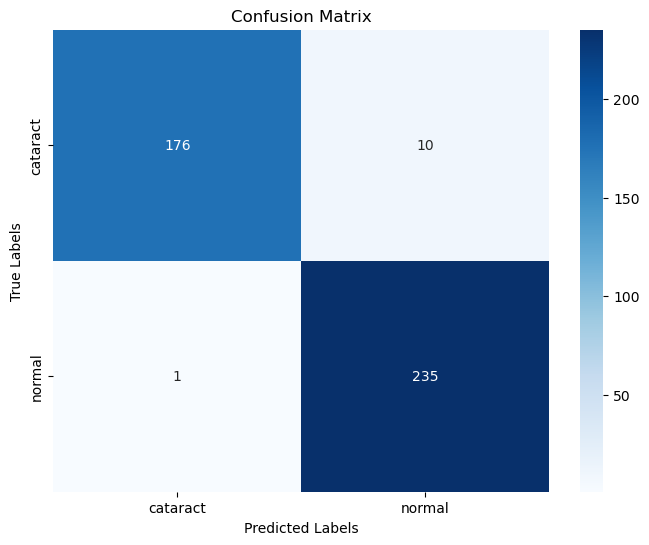

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = []
y_pred = []

for images, labels in validation_dataset:
    predictions = model.predict(images)
    
    y_pred_batch = np.argmax(predictions, axis=-1)  # Convert to class indices
    
    y_true.extend(labels.numpy())  # Collect true labels
    y_pred.extend(y_pred_batch)  # Collect predicted labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")

if len(y_true) == len(y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['cataract','normal'], yticklabels=['cataract', 'normal'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Mismatch in number of true labels and predicted labels.")


In [2]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_true = []
y_pred_prob = []

for images, labels in validation_dataset:
    predictions = model.predict(images)
    
    y_true.extend(labels.numpy())  # Collect true labels
    y_pred_prob.extend(predictions)  # Collect predicted probabilities

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred_prob: {len(y_pred_prob)}")

if len(y_true) == len(y_pred_prob):
    classes = np.unique(y_true)
    y_true_binarized = label_binarize(y_true, classes=classes)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange']
    for i, color in enumerate(colors[:len(classes)]):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Multi-class ROC Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("Mismatch in number of true labels and predicted labels.")

NameError: name 'validation_dataset' is not defined